In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [2]:
def create_NN_graph(nNodes,kij):
    
    G = nx.Graph()
    
    elist = []
    for i in range(nNodes-1):
        edge_tuple = (i,i+1,kij)
        elist.append(edge_tuple)
    G.add_weighted_edges_from(elist)
    return G

def create_bottleneck_k_matrix(nNodes,kij):
    
    k = np.zeros((nNodes,nNodes),dtype=float)

    for i in range(nNodes-1):
        for j in range(i+1,nNodes):
            # nearest neighbors are bonded
            if (abs(i-j)<2):
                k[i,j] = kij
            elif i < nNodes//2 and j < nNodes//2:
                k[i,j] = kij
            elif i > nNodes//2 and j > nNodes//2:
                k[i,j] = kij
            # symmetrize
            k[j,i] = k[i,j]
    return k

def k_to_hessian(k):
    hessian = -k
    for i in range(hessian.shape[0]):
        hessian[i,i] = -np.sum(hessian[i,:])
    return hessian

def compute_correlation_from_hessian(hess):
    M = hess.shape[0]
    hess_evals, hess_evecs = np.linalg.eigh(hess)
    # this translates to the following matrix equations
    gamma = np.diag(1.0/hess_evals)
    gamma[0,0] = 0.
    covar_from_hessian = np.dot(hess_evecs,np.dot(gamma,hess_evecs.T))*0.8
    analytic_corr = covar_to_correlation(covar_from_hessian)
    return analytic_corr, covar_from_hessian

def covar_to_correlation(covar):
    M = covar.shape[0]
    corr = np.empty((M,M),dtype=float)
    for i in range(M):
        for j in range(M):
             corr[i,j] = covar[i,j]/(np.sqrt(covar[i,i]*covar[j,j]))
    return corr

In [3]:
def centrality(A,n):
    e, v = np.linalg.eigh(A)
    centrality = np.zeros(A.shape[0])
    for i in range(1,n+1):
        centrality += 1.0/e[-i]*np.dot(A,v[:,-i])
    cmax = np.amax(-centrality)
    cmin = np.amin(-centrality)
    return 2 * (-centrality-cmin)/(cmax-cmin) - 1
    #return -centrality

In [4]:
nearestNeighborGraph = create_NN_graph(9,100.0)

In [5]:
nx.shortest_path(nearestNeighborGraph,source=0,target=8)

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
nx.to_numpy_matrix(nearestNeighborGraph)

matrix([[  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [100.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 100.,   0., 100.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0., 100.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 100.,   0., 100.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 100.,   0., 100.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 100.,   0., 100.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 100.,   0., 100.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 100.,   0.]])

In [7]:
k = create_bottleneck_k_matrix(9,100)
print(k)

[[  0. 100. 100. 100.   0.   0.   0.   0.   0.]
 [100.   0. 100. 100.   0.   0.   0.   0.   0.]
 [100. 100.   0. 100.   0.   0.   0.   0.   0.]
 [100. 100. 100.   0. 100.   0.   0.   0.   0.]
 [  0.   0.   0. 100.   0. 100.   0.   0.   0.]
 [  0.   0.   0.   0. 100.   0. 100. 100. 100.]
 [  0.   0.   0.   0.   0. 100.   0. 100. 100.]
 [  0.   0.   0.   0.   0. 100. 100.   0. 100.]
 [  0.   0.   0.   0.   0. 100. 100. 100.   0.]]


In [8]:
bottleneckHessian = k_to_hessian(k)
bottleneckCorr, bottleneckCovar = compute_correlation_from_hessian(bottleneckHessian)
bottleneckCorr

array([[ 1.        ,  0.70863309,  0.70863309,  0.66487846, -0.13621152,
        -0.75236247, -0.74820144, -0.74820144, -0.74820144],
       [ 0.70863309,  1.        ,  0.70863309,  0.66487846, -0.13621152,
        -0.75236247, -0.74820144, -0.74820144, -0.74820144],
       [ 0.70863309,  0.70863309,  1.        ,  0.66487846, -0.13621152,
        -0.75236247, -0.74820144, -0.74820144, -0.74820144],
       [ 0.66487846,  0.66487846,  0.66487846,  1.        ,  0.04732485,
        -0.72340426, -0.75236247, -0.75236247, -0.75236247],
       [-0.13621152, -0.13621152, -0.13621152,  0.04732485,  1.        ,
         0.04732485, -0.13621152, -0.13621152, -0.13621152],
       [-0.75236247, -0.75236247, -0.75236247, -0.72340426,  0.04732485,
         1.        ,  0.66487846,  0.66487846,  0.66487846],
       [-0.74820144, -0.74820144, -0.74820144, -0.75236247, -0.13621152,
         0.66487846,  1.        ,  0.70863309,  0.70863309],
       [-0.74820144, -0.74820144, -0.74820144, -0.75236247, -0

In [9]:
Ak = np.copy(k)
for i in range(Ak.shape[0]):
    for j in range(Ak.shape[1]):
        Ak[i,j] /= np.sqrt(np.sum(k[:,i])*np.sum(k[:,j]))
Ak

array([[0.        , 0.33333333, 0.33333333, 0.28867513, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.28867513, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.28867513, 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.28867513, 0.28867513, 0.28867513, 0.        , 0.35355339,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.35355339, 0.        ,
        0.35355339, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.35355339,
        0.        , 0.28867513, 0.28867513, 0.28867513],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.28867513, 0.        , 0.33333333, 0.33333333],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.28867513, 0.33333333, 0.        , 0.33333333],


In [10]:
cost_from_k = 1.0/k
for i in range(k.shape[0]): cost_from_k[i,i] = 0.0

#for i in range(9-2):
#    for j in range(i+2,9):
#        if k[i,j] > 0:
#            scaled_bottleneck[i,j] *= 1.0/k[i,j]
#            scaled_bottleneck[j,i] = scaled_bottleneck[i,j]
G_from_k_bottleneck = nx.from_numpy_matrix(cost_from_k)
nx.shortest_path(G_from_k_bottleneck,source=0,target=8,weight='weight')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


[0, 3, 4, 5, 8]

In [11]:
scaled_bottleneck

NameError: name 'scaled_bottleneck' is not defined

In [12]:
bottleneck_k_betweenness = nx.betweenness_centrality(G_from_k_bottleneck,weight='weight')

In [13]:
centralityK = centrality(Ak,1)

In [14]:
print(centralityCorr)

NameError: name 'centralityCorr' is not defined

In [15]:
pairDist = np.empty(k.shape,dtype=np.float64)
for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        pairDist[i,j] = abs(i-j)*2.0
pairDist

array([[ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.],
       [ 2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.],
       [ 4.,  2.,  0.,  2.,  4.,  6.,  8., 10., 12.],
       [ 6.,  4.,  2.,  0.,  2.,  4.,  6.,  8., 10.],
       [ 8.,  6.,  4.,  2.,  0.,  2.,  4.,  6.,  8.],
       [10.,  8.,  6.,  4.,  2.,  0.,  2.,  4.,  6.],
       [12., 10.,  8.,  6.,  4.,  2.,  0.,  2.,  4.],
       [14., 12., 10.,  8.,  6.,  4.,  2.,  0.,  2.],
       [16., 14., 12., 10.,  8.,  6.,  4.,  2.,  0.]])

In [16]:
ACorr = abs(bottleneckCorr-np.identity(bottleneckCorr.shape[0]))
ACorr_l1 = np.copy(ACorr)
lamb = 1.0
for i in range(ACorr.shape[0]):
    for j in range(ACorr.shape[1]):
        ACorr_l1[i,j] *= np.exp(-pairDist[i,j]/lamb)
centralityCorr = centrality(ACorr,1)
centralityCorr_l1 = centrality(ACorr_l1,1)

In [17]:
ACorr_l1 = 1.0/ACorr_l1
for i in range(ACorr_l1.shape[0]): ACorr_l1[i,i] = 0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [18]:
ACorr = 1.0/ACorr
for i in range(ACorr.shape[0]): ACorr[i,i] = 0.0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [19]:
G_from_Corr_bottleneck = nx.from_numpy_matrix(ACorr_l1)
print(nx.shortest_path(G_from_Corr_bottleneck,source=0,target=8,weight='weight'))
print(nx.betweenness_centrality(G_from_Corr_bottleneck,weight='weight'))
bottleneck_corr_l1_betweenness = nx.betweenness_centrality(G_from_Corr_bottleneck,weight='weight')

[0, 1, 2, 3, 5, 6, 7, 8]
{0: 0.0, 1: 0.25, 2: 0.42857142857142855, 3: 0.5357142857142857, 4: 0.0, 5: 0.5357142857142857, 6: 0.42857142857142855, 7: 0.25, 8: 0.0}


In [20]:
G_from_Corr_bottleneck = nx.from_numpy_matrix(ACorr)
print(nx.shortest_path(G_from_Corr_bottleneck,source=0,target=8,weight='weight'))
print(nx.betweenness_centrality(G_from_Corr_bottleneck,weight='weight'))
bottleneck_corr_betweenness = nx.betweenness_centrality(G_from_Corr_bottleneck,weight='weight')

[0, 8]
{0: 0.0, 1: 0.03571428571428571, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.011904761904761904, 7: 0.011904761904761904, 8: 0.011904761904761904}


In [21]:
ACorr

array([[ 0.        ,  1.41116751,  1.41116751,  1.50403428,  7.34152295,
         1.32914657,  1.33653846,  1.33653846,  1.33653846],
       [ 1.41116751,  0.        ,  1.41116751,  1.50403428,  7.34152295,
         1.32914657,  1.33653846,  1.33653846,  1.33653846],
       [ 1.41116751,  1.41116751,  0.        ,  1.50403428,  7.34152295,
         1.32914657,  1.33653846,  1.33653846,  1.33653846],
       [ 1.50403428,  1.50403428,  1.50403428,  0.        , 21.13054661,
         1.38235294,  1.32914657,  1.32914657,  1.32914657],
       [ 7.34152295,  7.34152295,  7.34152295, 21.13054661,  0.        ,
        21.13054661,  7.34152295,  7.34152295,  7.34152295],
       [ 1.32914657,  1.32914657,  1.32914657,  1.38235294, 21.13054661,
         0.        ,  1.50403428,  1.50403428,  1.50403428],
       [ 1.33653846,  1.33653846,  1.33653846,  1.32914657,  7.34152295,
         1.50403428,  0.        ,  1.41116751,  1.41116751],
       [ 1.33653846,  1.33653846,  1.33653846,  1.32914657,  7

In [22]:
k

array([[  0., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.],
       [100.,   0., 100., 100.,   0.,   0.,   0.,   0.,   0.],
       [100., 100.,   0., 100.,   0.,   0.,   0.,   0.,   0.],
       [100., 100., 100.,   0., 100.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0., 100.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 100.,   0., 100., 100., 100.],
       [  0.,   0.,   0.,   0.,   0., 100.,   0., 100., 100.],
       [  0.,   0.,   0.,   0.,   0., 100., 100.,   0., 100.],
       [  0.,   0.,   0.,   0.,   0., 100., 100., 100.,   0.]])

In [23]:
bottleneck_k_betweenness[2]

0.0

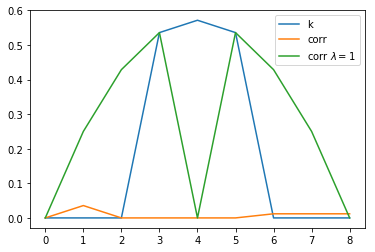

In [24]:
plt.plot(*zip(*sorted(bottleneck_k_betweenness.items())),label="k")
plt.plot(*zip(*sorted(bottleneck_corr_betweenness.items())),label="corr")
plt.plot(*zip(*sorted(bottleneck_corr_l1_betweenness.items())),label="corr $\lambda=1$")
#plt.plot(centralityCorr_l5,label="corr $\lambda=5$")
#plt.plot(centralityCorr_l10,label="corr $\lambda=10$")
#plt.plot(centralityCorr_l15,label="corr $\lambda=15$")
#plt.plot(centralityCorr_l50,label="corr $\lambda=50$")
plt.legend()

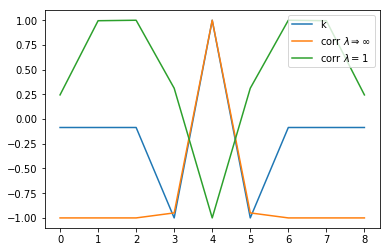

In [25]:
plt.plot(centralityK,label="k")
plt.plot(centralityCorr,label="corr $\lambda\Rightarrow\infty$")
plt.plot(centralityCorr_l1,label="corr $\lambda=1$")
#plt.plot(centralityCorr_l10,label="corr $\lambda=10$")
#plt.plot(centralityCorr_l15,label="corr $\lambda=15$")
#plt.plot(centralityCorr_l50,label="corr $\lambda=50$")
plt.legend()

In [26]:
# create the hessian matrix for the 9 node nearest neighbor spring system
kij = 303.1
b = 2
k_9  = create_NN_k_matrix(9,kij)
k_9

NameError: name 'create_NN_k_matrix' is not defined

In [27]:
k2 = k_9 + np.ones((9,9))
x2 = np.zeros(9)
x2[0] = -kij * b
x2[8] = -x2[0]
print(np.dot(np.linalg.inv(k2),x2))


NameError: name 'k_9' is not defined

In [7]:
# diagonlize the hessian
k_9_evals, k_9_evecs = np.linalg.eigh(k_9)
idx = k_9_evals.argsort()
k_9_evals = k_9_evals[idx]
k_9_evecs = k_9_evecs[:,idx]
#print k_9_evecs
k_9_evals

array([-1.68562619e-13,  3.65583333e+01,  1.41823859e+02,  3.03100000e+02,
        5.00934475e+02,  7.11465525e+02,  9.09300000e+02,  1.07057614e+03,
        1.17584167e+03])

In [8]:
# here I use the eq 13 from Chennubhotla et al to compute the covariance directly from eigenvectors 
covar_from_hessian = np.zeros((9,9),dtype=float)
for i in range(9):
    for j in range(9):
        for k in range(1,9):
            covar_from_hessian[i,j] += 1.0/k_9_evals[k] * k_9_evecs[i,k] * k_9_evecs[j,k]
covar_from_hessian *= 0.8
covar_from_hessian

array([[ 6.64736000e-03,  4.30123294e-03,  2.24837176e-03,
         4.88776470e-04, -9.77552941e-04, -2.15061647e-03,
        -3.03041412e-03, -3.61694588e-03, -3.91021176e-03],
       [ 4.30123294e-03,  4.59449882e-03,  2.54163765e-03,
         7.82042352e-04, -6.84287058e-04, -1.85735059e-03,
        -2.73714823e-03, -3.32368000e-03, -3.61694588e-03],
       [ 2.24837176e-03,  2.54163765e-03,  3.12816941e-03,
         1.36857412e-03, -9.77552941e-05, -1.27081882e-03,
        -2.15061647e-03, -2.73714823e-03, -3.03041412e-03],
       [ 4.88776470e-04,  7.82042352e-04,  1.36857412e-03,
         2.24837176e-03,  7.82042352e-04, -3.91021176e-04,
        -1.27081882e-03, -1.85735059e-03, -2.15061647e-03],
       [-9.77552941e-04, -6.84287058e-04, -9.77552941e-05,
         7.82042352e-04,  1.95510588e-03,  7.82042352e-04,
        -9.77552941e-05, -6.84287058e-04, -9.77552941e-04],
       [-2.15061647e-03, -1.85735059e-03, -1.27081882e-03,
        -3.91021176e-04,  7.82042352e-04,  2.248371

In [9]:
# this translates to the following matrix equations
gamma = np.diag(1.0/k_9_evals)
gamma[0,0] = 0.
covar_from_hessian = np.dot(k_9_evecs,np.dot(gamma,k_9_evecs.T))*0.8

In [10]:
# read in Heidi's covariance matrix from simulation
covar = np.loadtxt("covariance_nearest_neighbors.dat")

In [11]:
covar

array([[ 2.59838681e-01,  1.95319707e-01,  1.29544999e-01,
         6.42267926e-02, -9.65443900e-04, -6.58313480e-02,
        -1.30396198e-01, -1.94496103e-01, -2.57241087e-01],
       [ 1.95319707e-01,  1.48545895e-01,  9.84698511e-02,
         4.87963257e-02, -5.98519265e-04, -4.99003397e-02,
        -9.88095613e-02, -1.47216312e-01, -1.94607047e-01],
       [ 1.29544999e-01,  9.84698511e-02,  6.69587511e-02,
         3.32984579e-02, -3.54654228e-05, -3.33209903e-02,
        -6.60927076e-02, -9.85459933e-02, -1.30276902e-01],
       [ 6.42267926e-02,  4.87963257e-02,  3.32984579e-02,
         1.81253852e-02,  8.67708638e-04, -1.63223865e-02,
        -3.32249700e-02, -4.98196740e-02, -6.59476395e-02],
       [-9.65443900e-04, -5.98519265e-04, -3.54654228e-05,
         8.67708638e-04,  2.01574396e-03,  8.06643231e-04,
        -1.45371457e-04, -7.72989821e-04, -1.17230596e-03],
       [-6.58313480e-02, -4.99003397e-02, -3.33209903e-02,
        -1.63223865e-02,  8.06643231e-04,  1.829900

In [12]:
# let's try and recompute Heidi's covariance
heidi_traj = np.loadtxt("positions.dat")
nSteps = heidi_traj.shape[0]
nNodes = heidi_traj.shape[1]
covar = np.zeros((nNodes,nNodes),dtype=np.float64)
avg = np.zeros(nNodes,dtype=np.float64)
for step in range(100,nSteps):
    # substract center-of-geometry
    heidi_traj[step,:] -= np.mean(heidi_traj[step,:])
    # add to average
    avg += heidi_traj[step,:]
    # add to covar
    covar += np.dot(heidi_traj[step,:].reshape(nNodes,1),heidi_traj[step,:].reshape(1,nNodes))
# finish averages
avg /= (nSteps-100)
covar /= (nSteps-100)
# finish covar
covar -= np.dot(avg.reshape(nNodes,1),avg.reshape(1,nNodes))
print(covar)

[[ 6.89239367e-03  4.55797829e-03  2.39296983e-03  6.59570222e-04
  -1.01795676e-03 -2.27220798e-03 -3.22333084e-03 -3.74709003e-03
  -4.24232639e-03]
 [ 4.55797829e-03  4.69107097e-03  2.61292983e-03  8.80520361e-04
  -6.51146579e-04 -1.97944322e-03 -2.90199899e-03 -3.36907819e-03
  -3.84083248e-03]
 [ 2.39296983e-03  2.61292983e-03  3.05692075e-03  1.36881890e-03
  -5.71216585e-05 -1.39411684e-03 -2.18648175e-03 -2.65446295e-03
  -3.13945610e-03]
 [ 6.59570222e-04  8.80520361e-04  1.36881890e-03  2.13391719e-03
   8.41670530e-04 -3.67320210e-04 -1.28674043e-03 -1.87630040e-03
  -2.35413615e-03]
 [-1.01795676e-03 -6.51146579e-04 -5.71216585e-05  8.41670530e-04
   2.02069905e-03  8.09323836e-04 -1.08321114e-04 -7.20718141e-04
  -1.11642917e-03]
 [-2.27220798e-03 -1.97944322e-03 -1.39411684e-03 -3.67320210e-04
   8.09323836e-04  2.35190928e-03  1.46704619e-03  8.44672554e-04
   5.40136377e-04]
 [-3.22333084e-03 -2.90199899e-03 -2.18648175e-03 -1.28674043e-03
  -1.08321114e-04  1.4670461

In [13]:
covar/covar_from_hessian

array([[1.0368618 , 1.05969111, 1.06431235, 1.34943121, 1.04133159,
        1.05653798, 1.06366019, 1.03598178, 1.0849352 ],
       [1.05969111, 1.02101908, 1.02804971, 1.12592414, 0.95156933,
        1.06573483, 1.06022719, 1.01365901, 1.06189935],
       [1.06431235, 1.02804971, 0.97722353, 1.00017886, 0.58433315,
        1.0970225 , 1.01667675, 0.96979145, 1.03598254],
       [1.34943121, 1.12592414, 1.00017886, 0.94909446, 1.07624674,
        0.939387  , 1.01252862, 1.01020261, 1.09463318],
       [1.04133159, 0.95156933, 0.58433315, 1.07624674, 1.03354968,
        1.03488492, 1.10808437, 1.05323947, 1.14206517],
       [1.05653798, 1.06573483, 1.0970225 , 0.939387  , 1.03488492,
        1.04605   , 1.07195232, 1.08008543, 1.10507852],
       [1.06366019, 1.06022719, 1.01667675, 1.01252862, 1.10808437,
        1.07195232, 1.02645283, 1.00208881, 1.10389304],
       [1.03598178, 1.01365901, 0.96979145, 1.01020261, 1.05323947,
        1.08008543, 1.00208881, 0.97627761, 1.0440086 ],


In [54]:
avg_positions = np.mean(heidi_traj[100:1000,:],axis=0)
print(avg_positions)

[ 8.00003117e+00  6.00025427e+00  3.99949913e+00  1.99962869e+00
 -2.23259477e-04 -1.99977622e+00 -4.00007650e+00 -5.99959145e+00
 -7.99974583e+00]


In [57]:
400*np.mean(covar/covar_from_hessian)

34.03472602882426

In [15]:
def covar_to_correlation(covar):
    M = covar.shape[0]
    corr = np.empty((M,M),dtype=float)
    for i in range(M):
        for j in range(M):
             corr[i,j] = covar[i,j]/(np.sqrt(covar[i,i]*covar[j,j]))
    return corr

In [16]:
measured_corr = covar_to_correlation(covar)
analytic_corr = covar_to_correlation(covar_from_hessian)

In [17]:
measured_corr

array([[ 1.        ,  0.99945206,  0.9984152 ,  0.99337606, -0.0081234 ,
        -0.99586226, -0.99879812, -0.99916456, -0.99911353],
       [ 0.99945206,  1.        ,  0.99890477,  0.99416279, -0.00455694,
        -0.99600434, -0.99904494, -0.99933843, -0.99921991],
       [ 0.9984152 ,  0.99890477,  1.        ,  0.99566139,  0.00327394,
        -0.99554416, -0.99880256, -0.99906602, -0.99892212],
       [ 0.99337606,  0.99416279,  0.99566139,  1.        ,  0.04868483,
        -0.99067676, -0.9954747 , -0.99586581, -0.99565124],
       [-0.0081234 , -0.00455694,  0.00327394,  0.04868483,  1.        ,
         0.03219789, -0.01035151, -0.01687798, -0.01710707],
       [-0.99586226, -0.99600434, -0.99554416, -0.99067676,  0.03219789,
         1.        ,  0.9957599 ,  0.99429518,  0.99381556],
       [-0.99879812, -0.99904494, -0.99880256, -0.9954747 , -0.01035151,
         0.9957599 ,  1.        ,  0.99892536,  0.99838423],
       [-0.99916456, -0.99933843, -0.99906602, -0.99586581, -0

In [18]:
analytic_corr

array([[ 1.        ,  0.77830405,  0.49305843,  0.12643043, -0.27116307,
        -0.55629391, -0.66455702, -0.65448295, -0.58823529],
       [ 0.77830405,  1.        ,  0.67042381,  0.24331963, -0.22831483,
        -0.57788411, -0.72199487, -0.72340426, -0.65448295],
       [ 0.49305843,  0.67042381,  1.        ,  0.51604685, -0.03952847,
        -0.47918636, -0.6875    , -0.72199487, -0.66455702],
       [ 0.12643043,  0.24331963,  0.51604685,  1.        ,  0.37300192,
        -0.17391304, -0.47918636, -0.57788411, -0.55629391],
       [-0.27116307, -0.22831483, -0.03952847,  0.37300192,  1.        ,
         0.37300192, -0.03952847, -0.22831483, -0.27116307],
       [-0.55629391, -0.57788411, -0.47918636, -0.17391304,  0.37300192,
         1.        ,  0.51604685,  0.24331963,  0.12643043],
       [-0.66455702, -0.72199487, -0.6875    , -0.47918636, -0.03952847,
         0.51604685,  1.        ,  0.67042381,  0.49305843],
       [-0.65448295, -0.72340426, -0.72199487, -0.57788411, -0

In [17]:
np.savetxt("9node_nearestneighbor_analytic_corr.dat",analytic_corr)

In [70]:
def compute_correlation_from_hessian(hess):
    M = hess.shape[0]
    hess_evals, hess_evecs = np.linalg.eig(hess)
    # sort eigenvectors and eigenvalues in ascending order (of eigenvalues)
    idx = hess_evals.argsort()
    hess_evals = hess_evals[idx]
    hess_evecs = hess_evecs[:,idx]
    print(hess_evecs)
    # this translates to the following matrix equations
    gamma = np.diag(1.0/hess_evals)
    gamma[0,0] = 0.
    covar_from_hessian = np.dot(hess_evecs,np.dot(gamma,hess_evecs.T))*0.8
    analytic_corr = covar_to_correlation(covar_from_hessian)
    return analytic_corr, covar_from_hessian

In [71]:
k9_NN_plus_19 = np.copy(k_9)
k9_NN_plus_19[0,8] = k9_NN_plus_19[8,0] = -kij
k9_NN_plus_19[0,0] += kij
k9_NN_plus_19[8,8] += kij
print(k9_NN_plus_19)

[[ 606.2 -303.1    0.     0.     0.     0.     0.     0.  -303.1]
 [-303.1  606.2 -303.1    0.     0.     0.     0.     0.     0. ]
 [   0.  -303.1  606.2 -303.1    0.     0.     0.     0.     0. ]
 [   0.     0.  -303.1  606.2 -303.1    0.     0.     0.     0. ]
 [   0.     0.     0.  -303.1  606.2 -303.1    0.     0.     0. ]
 [   0.     0.     0.     0.  -303.1  606.2 -303.1    0.     0. ]
 [   0.     0.     0.     0.     0.  -303.1  606.2 -303.1    0. ]
 [   0.     0.     0.     0.     0.     0.  -303.1  606.2 -303.1]
 [-303.1    0.     0.     0.     0.     0.     0.  -303.1  606.2]]


In [72]:
k9_NN_plus_19_corr, k9_NN_plus_19_covar = compute_correlation_from_hessian(k9_NN_plus_19)

[[ 0.33333333 -0.47140452  0.18079434  0.05798414 -0.47140452  0.47140452
   0.02577337 -0.47140452 -0.03523236]
 [ 0.33333333 -0.36111681 -0.14134552  0.47078635 -0.08185854 -0.23570226
   0.39475098  0.44297535  0.19388649]
 [ 0.33333333 -0.08185854 -0.39734824  0.10551824  0.44297535 -0.23570226
  -0.42052435 -0.36111681 -0.32915505]
 [ 0.33333333  0.23570226 -0.4674273  -0.43414025  0.23570226  0.47140452
   0.02577337  0.23570226  0.42472265]
 [ 0.33333333  0.44297535 -0.31879194 -0.25629357 -0.36111681 -0.23570226
   0.39475098 -0.08185854 -0.46906243]
 [ 0.33333333  0.44297535 -0.02099028  0.34513042 -0.36111681 -0.23570226
  -0.42052435 -0.08185854  0.45682636]
 [ 0.33333333  0.23570226  0.28663296  0.37615611  0.23570226  0.47140452
   0.02577337  0.23570226 -0.38949029]
 [ 0.33333333 -0.08185854  0.46013746 -0.21449278  0.44297535 -0.23570226
   0.39475098 -0.36111681  0.27517594]
 [ 0.33333333 -0.36111681  0.41833852 -0.45064867 -0.08185854 -0.23570226
  -0.42052435  0.44297

In [67]:
k9_NN_plus_19_covar

array([[ 2.14628281e-03,  6.85793749e-04, -4.94855114e-04,
        -1.21077956e-03, -1.30620309e-03, -9.87485775e-04,
        -3.47218222e-04,  3.53996812e-04,  1.16046839e-03],
       [ 6.85793749e-04,  1.55800606e-03,  2.55549848e-04,
        -4.26405445e-04, -6.94219893e-04, -6.40484104e-04,
        -5.25800835e-04, -3.05861017e-04,  9.34216348e-05],
       [-4.94855114e-04,  2.55549848e-04,  1.62645573e-03,
         7.72109518e-04,  2.39313542e-04, -2.32534953e-04,
        -5.99126899e-04, -7.86376012e-04, -7.80535661e-04],
       [-1.21077956e-03, -4.26405445e-04,  7.72109518e-04,
         2.29217472e-03,  1.23379446e-03,  2.80670747e-04,
        -4.93110130e-04, -1.07380154e-03, -1.37465276e-03],
       [-1.30620309e-03, -6.94219893e-04,  2.39313542e-04,
         1.23379446e-03,  2.33353192e-03,  9.73219281e-04,
        -1.94003897e-04, -1.08138688e-03, -1.50404545e-03],
       [-9.87485775e-04, -6.40484104e-04, -2.32534953e-04,
         2.80670747e-04,  9.73219281e-04,  1.858857

In [46]:
np.savetxt("9node_nearestneighbor_plus_1_9_analytic_corr.dat",k9_NN_plus_19_corr)

In [23]:
# read in Heidi's covariance matrix from simulation
covar_19 = np.loadtxt("covariance_9springs.dat")
corr_19 = covar_to_correlation(covar_19)
corr_19

array([[ 1.        ,  0.77481132,  0.46789818,  0.12223329, -0.25633782,
        -0.54909246, -0.65111888, -0.64809241, -0.58738084],
       [ 0.77481132,  1.        ,  0.65834024,  0.23880768, -0.21971135,
        -0.58376429, -0.71670579, -0.71474891, -0.64808748],
       [ 0.46789818,  0.65834024,  1.        ,  0.51733209, -0.0226599 ,
        -0.48742043, -0.68769036, -0.70782996, -0.64557873],
       [ 0.12223329,  0.23880768,  0.51733209,  1.        ,  0.38273453,
        -0.18233004, -0.47982085, -0.58839961, -0.54777559],
       [-0.25633782, -0.21971135, -0.0226599 ,  0.38273453,  1.        ,
         0.37408833, -0.04471319, -0.24910118, -0.29611406],
       [-0.54909246, -0.58376429, -0.48742043, -0.18233004,  0.37408833,
         1.        ,  0.52754451,  0.24066997,  0.12319119],
       [-0.65111888, -0.71670579, -0.68769036, -0.47982085, -0.04471319,
         0.52754451,  1.        ,  0.65894549,  0.47828699],
       [-0.64809241, -0.71474891, -0.70782996, -0.58839961, -0

In [90]:
def linear_MI_rMI_from_covar(covar,d=1):
    # size of the array for MI and rMI is the number of nodes
    N = covar.shape[0]//d
    # declare MI and rMI matrices
    rMI = np.zeros((N,N),dtype=float)
    MI = np.zeros((N,N),dtype=float)
    # check dimensionality of system - 1D we need to avoid taking determinants
    if (d==1):
        # loop over unique pairs of nodes
        for i in range(N-1):
            for j in range(i+1,N):
                # compute numerator in argument of log of linear MI equation
                temp = covar[i,i]*covar[j,j]
                # compute linear MI (eq 10 of Grubmuller 2005)
                MI[i,j] = 0.5*np.log(temp/(temp-covar[i,j]**2))
                # symmetrize MI
                MI[j,i] = MI[i,j]
                # compute rMI (eq 9 from Grubmuller 2005 with sqrt instead of inverse sqrt - typo in paper)
                rMI[i,j] = np.sqrt(1.0-np.exp(-2.0*MI[i,j]/d))
                # symmetrize rMI
                rMI[j,i] = rMI[i,j]
    else:
        # loop over unique pairs of nodes
        for i in range(N-1):
            # i index assuming that each node has d values sequentially populating the covar matrix
            iIndex = i*d
            for j in range(i+1,N):
                # j index assuming that each node has d values sequentially populating the covar matrix
                jIndex = j*d
                # compute numerator in argument of log of linear MI equation
                temp = np.linalg.det(covar[iIndex:iIndex+d,iIndex:iIndex+d])*np.linalg.det(covar[jIndex:jIndex+d,jIndex:jIndex+d])
                # make list of indeces for the 2d X 2d C_ij matrix
                idx = np.append(np.arange(iIndex,iIndex+d,1),np.arange(jIndex,jIndex+d,1))
                # compute linear MI (eq 10 of Grubmuller 2005)
                MI[i,j] = 0.5*np.log(temp/np.linalg.det(covar[np.ix_(idx,idx)]))
                # symmetrize
                MI[j,i] = MI[i,j]
                # compute rMI (eq 9 from Grubmuller 2005 with sqrt instead of inverse sqrt - typo in paper)
                rMI[i,j] = np.sqrt(1.0-np.exp(-2.0*MI[i,j]/d))
                # symmetrize
                rMI[j,i] = rMI[i,j]
    
    # populate diagonal elements of MI and rMI
    MI += np.diag(np.full(N,np.inf))
    rMI += np.diag(np.ones(N))
    # return MI and rMI
    return MI,rMI    

def linear_MI_from_covar(covar):
    M = covar.shape[0]
    MI = np.empty((M,M))
    for i in range(M):
        for j in range(M):
            temp = covar[i,i]*covar[j,j]
            MI[i,j] = 0.5*np.log(temp/(temp-covar[i,j]**2))
    return MI

In [91]:
k9_NN_plus_19_MI,k9_NN_plus_19_rMI  = linear_rMI_from_covar(k9_NN_plus_19_covar,d=3)
k9_NN_plus_19_rMI
k9_NN_plus_19_MI

array([[        inf,  0.56419694,  0.52337777],
       [ 0.56419694,         inf,  0.46543099],
       [ 0.52337777,  0.46543099,         inf]])

In [77]:
idx = np.arange(0,3,1)
idx = np.append(idx,np.arange(6,9,1))
print idx

[0 1 2 6 7 8]


In [86]:
k9_NN_plus_19_covar[np.ix_(idx,idx)].shape

(6, 6)

In [87]:
k9_NN_plus_19_covar[0:3,0:3]

array([[ 0.0020633 ,  0.0009458 ,  0.00021641],
       [ 0.0009458 ,  0.00226928,  0.00108312],
       [ 0.00021641,  0.00108312,  0.00198056]])

In [78]:
N=9
np.diag(np.ones(N))

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [99]:
np.linalg.inv(covar_from_hessian)

array([[  2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17],
       [  2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17],
       [  2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17],
       [  2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17],
       [  2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
          2.54104705e+17,   2.54104705e+17,   2.54104705e+17],
       [  2.54104705e+17,   2.54104705e+17,   2.54104705e+17,
   

In [109]:
alpha, a = np.linalg.eig(covar_from_hessian/0.8)
idx = alpha.argsort()
alpha = alpha[idx]
a = a[:,idx]
print alpha

[ -8.12377476e-19   8.50454639e-04   9.34076486e-04   1.09974706e-03
   1.40554948e-03   1.99626907e-03   3.29924117e-03   7.05099981e-03
   2.73535446e-02]


In [107]:
kappa = np.diag(1.0/alpha)
kappa[0,0] = 0.
krev = np.dot(a,np.dot(kappa,a.T))

In [108]:
print krev

[[  3.03100000e+02  -3.03100000e+02  -4.22307160e-13  -5.94107248e-14
   -7.03659693e-13   1.17074531e-12  -6.70469884e-13   1.35620439e-13
   -4.92939023e-13]
 [ -3.03100000e+02   6.06200000e+02  -3.03100000e+02  -2.45859587e-13
    1.83509436e-12  -1.27895508e-12   6.65069987e-13  -6.77127462e-14
    9.97424365e-13]
 [ -4.12231950e-13  -3.03100000e+02   6.06200000e+02  -3.03100000e+02
   -5.17500427e-13   1.21263129e-12  -1.01162423e-12  -5.36641355e-13
    2.66453526e-14]
 [ -6.60800893e-14  -2.44197202e-13  -3.03100000e+02   6.06200000e+02
   -3.03100000e+02  -3.88243051e-14  -9.64877539e-13   1.12120262e-12
   -5.92415006e-13]
 [ -7.15566924e-13   1.83141545e-12  -5.25333339e-13  -3.03100000e+02
    6.06200000e+02  -3.03100000e+02   1.55072447e-12  -4.87230478e-13
    2.78145932e-13]
 [  1.18123999e-12  -1.26566923e-12   1.24105233e-12  -9.57272791e-14
   -3.03100000e+02   6.06200000e+02  -3.03100000e+02  -4.67984278e-13
    6.92335078e-13]
 [ -6.80011692e-13   6.07847084e-13  -1.

In [ ]:
def k_from_covar(covar):
    alpha, a = np.linalg.eig(covar_from_hessian/0.8)
    idx = alpha.argsort()
    alpha = alpha[idx]
    a = a[:,idx]
    kappa = np.diag(1.0/alpha)
    kappa[0,0] = 0.
    krev = np.dot(a,np.dot(kappa,a.T))
    return krev